In [1]:
%pylab notebook

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
from datetime import datetime

In [3]:
(3921445268.51841-3921389441.03423)/3600

15.507634494437111

<IPython.core.display.Javascript object>


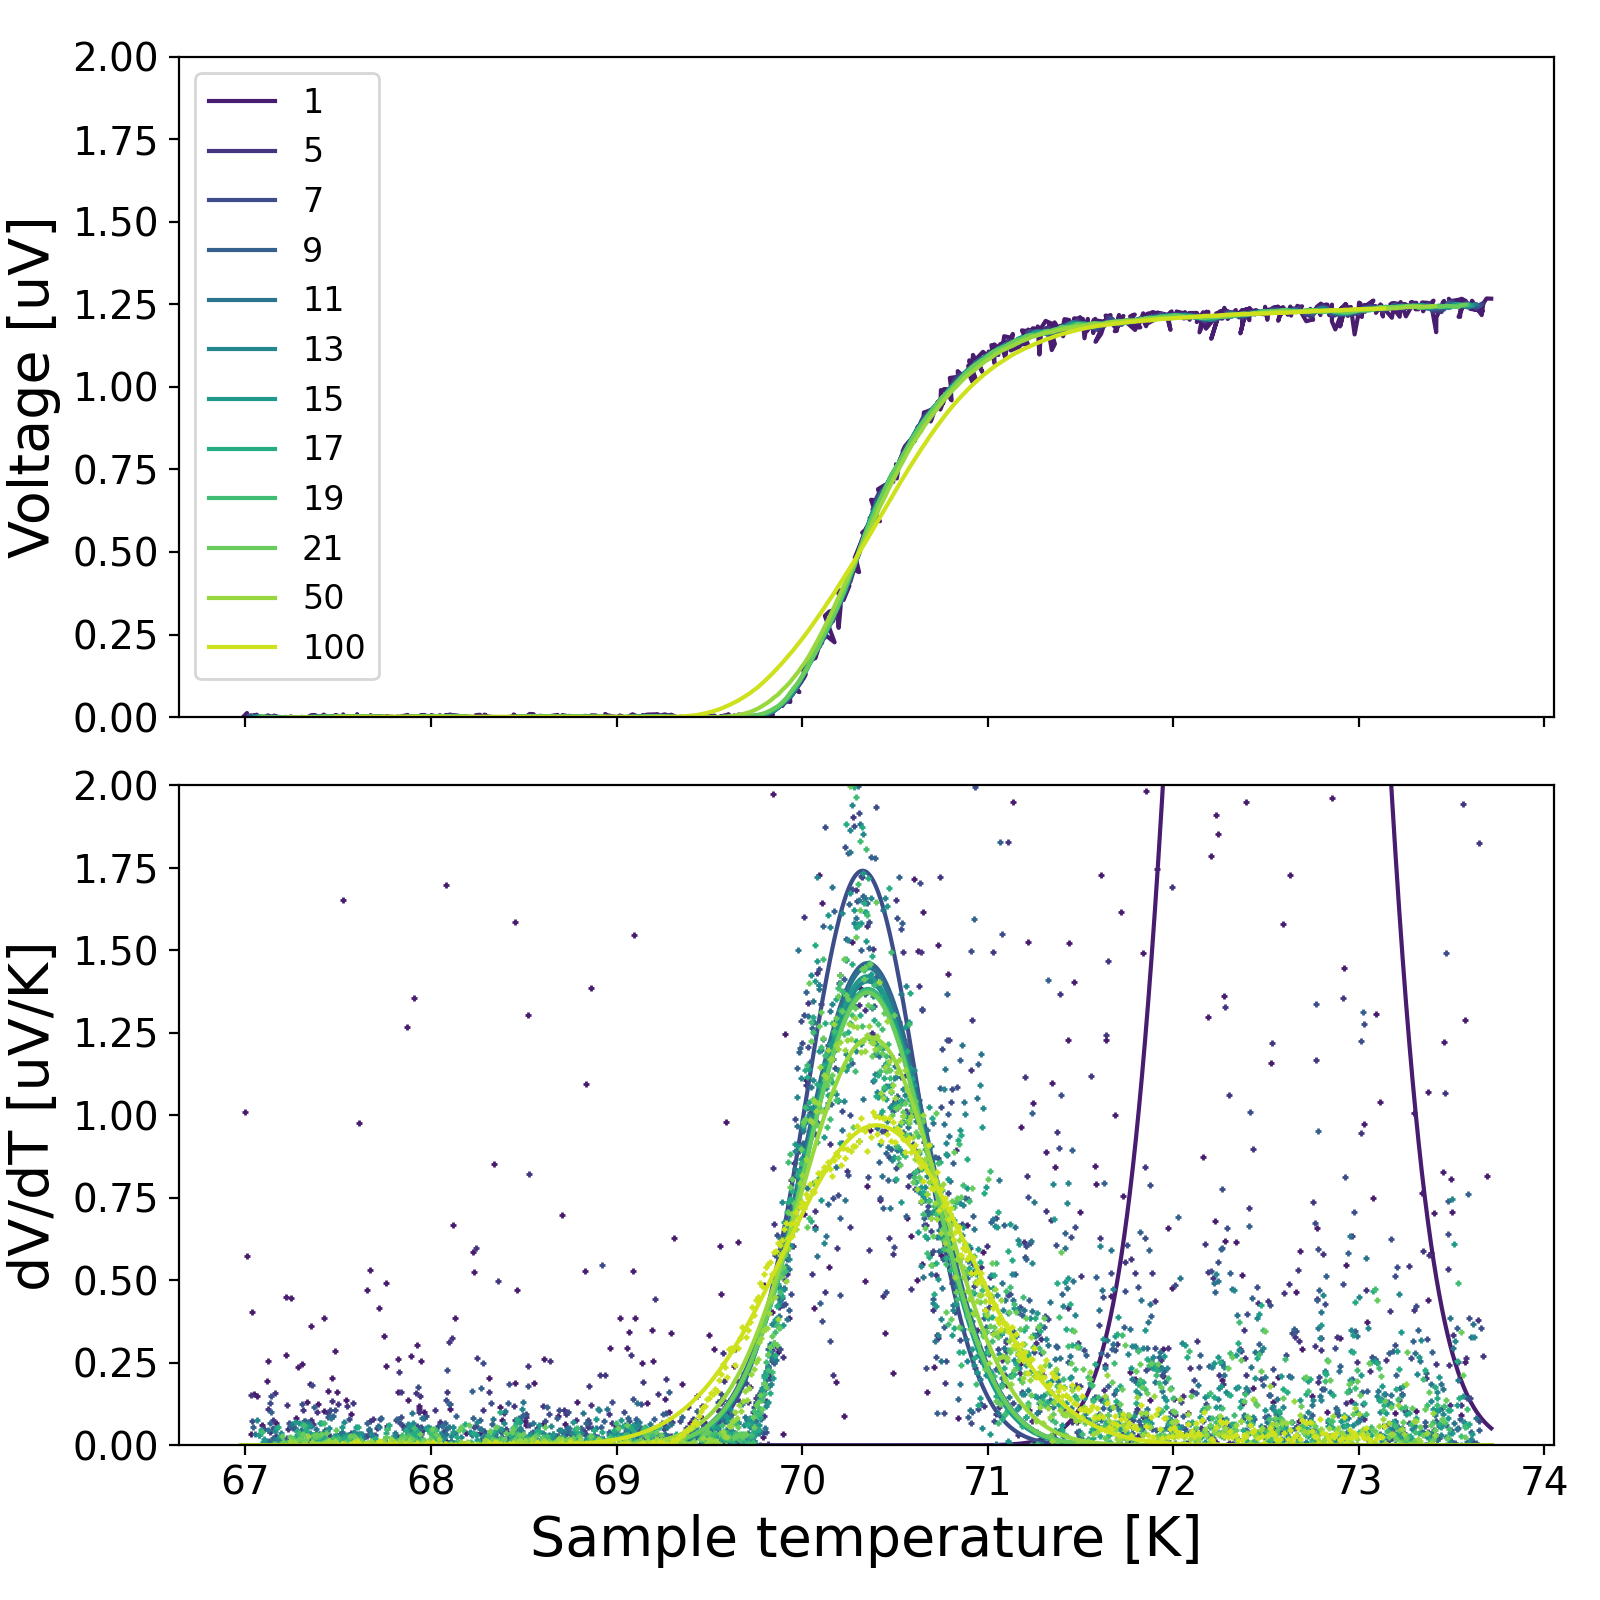

<IPython.core.display.Javascript object>


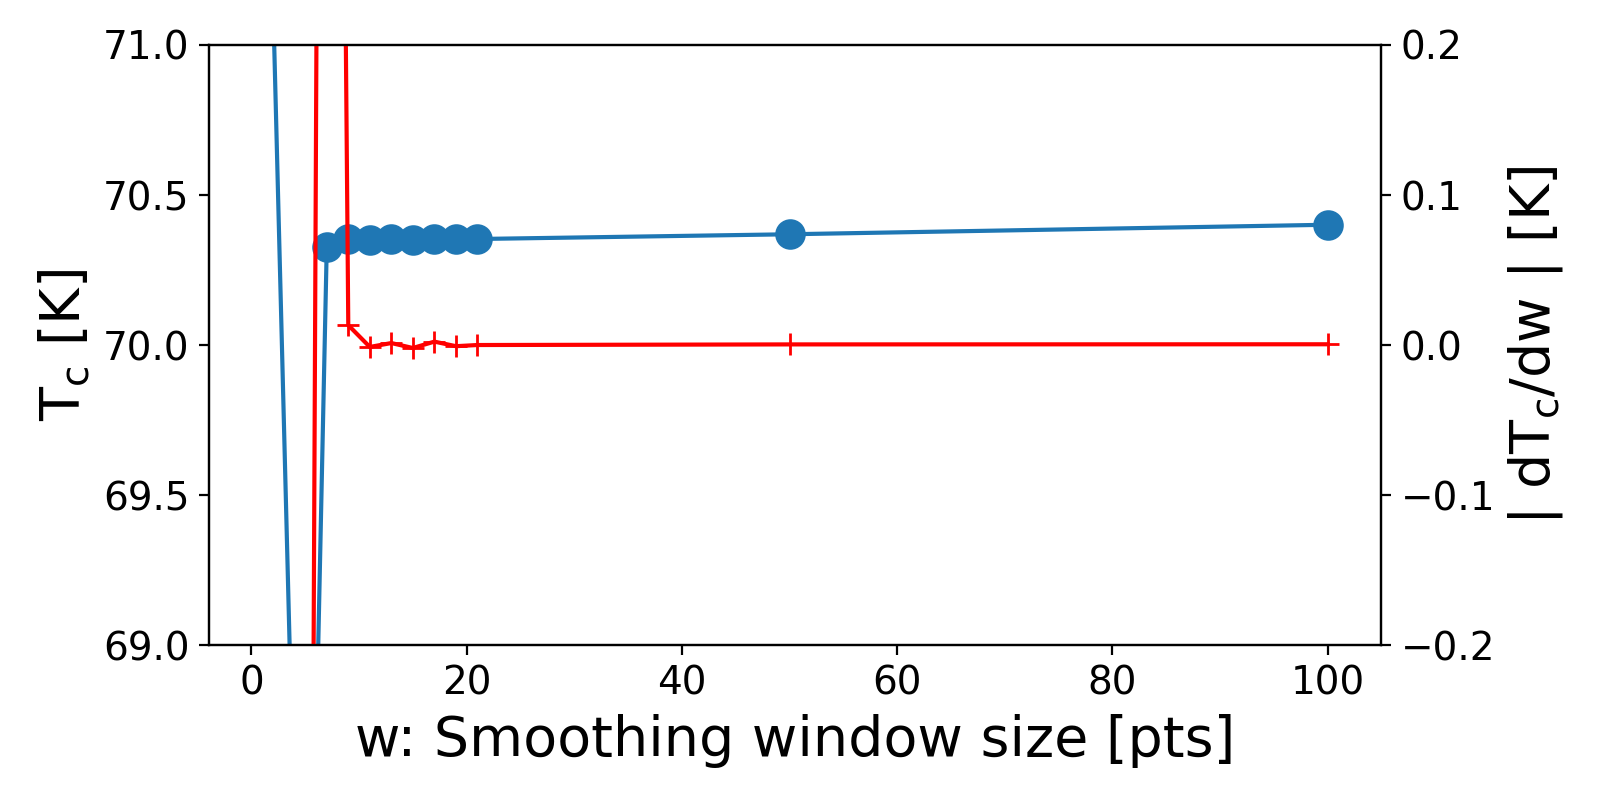

In [6]:
import sys
sys.path.append('/Users/alexisdevitre/Documents/code/hts-irradiation')
import hts_fitting as hts
from scipy.optimize import curve_fit
import scipy.special as spe
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns

def gaussian(x, a0, mu, sigma):
    return a0*np.exp(-.5*((x - mu)/sigma)**2)/(sigma*np.sqrt(2*np.pi))

def skewedGaussian(x, a0, mu, sigma, alpha):
    return gaussian(x, a0, mu, sigma) * (1 + scipy.spe.erf(alpha*(x-mu)/np.sqrt(2)))


########## CHANGE THIS ##########

fexample = '/Users/alexisdevitre/MIT Dropbox/Alexis Devitre/2020 PhD/Research/data/Coated conductors/FFJ/ffj37/Tc/Tc_2024-04-01_09-42-05830506_f37-05kmin-upwards.txt'
windowSize, tc = [1, 5, 7, 9, 11, 13, 15, 17, 19, 21, 50, 100], []
colors = sns.color_palette('viridis', len(windowSize))
ffunction = gaussian

########## CHANGE THIS ##########


data = hts.readTV(fexample)
xsmooth = np.linspace(data.sampleT.min(), data.sampleT.max(), 100000)
fig, ax = plt.subplots(2, 1, sharex=True)

for wsz, c in zip(windowSize, colors):
    rdata = data.rolling(wsz).mean()
    vdT = (rdata.voltage.diff()/rdata.sampleT.diff())
    cut = np.isfinite(vdT).values
    temperature, vdT = rdata.sampleT[cut], vdT[cut]
    ax[0].plot(rdata.sampleT, 1e6*rdata.voltage, label=wsz, color=c)
    ax[1].plot(temperature, 1e6*vdT, linestyle='None', marker='+', markersize=2, color=c)
    popt, pcov = curve_fit(ffunction, temperature, vdT, p0=[2, rdata.sampleT[(rdata.voltage-rdata.voltage.max()/2).abs().argmin()], 1])
    ysmooth = ffunction(xsmooth, *popt)
    ax[1].plot(xsmooth, 1e6*ysmooth, color=c)
    tc.append(xsmooth[np.argmax(ysmooth)])
    
ax[0].set_ylabel('Voltage [uV]')
ax[1].set_ylabel('dV/dT [uV/K]')
ax[1].set_xlabel('Sample temperature [K]')
ax[0].set_ylim(0, 2)
ax[1].set_ylim(0, 2)    
ax[0].legend()
fig.tight_layout()


fig, ax = plt.subplots(figsize=(8, 4))
bx = ax.twinx()
ax.plot(windowSize, tc, marker='o', markersize=10)
bx.plot(windowSize[1:], np.diff(tc)/np.diff(windowSize), marker='+', color='r')
ax.set_xlabel('w: Smoothing window size [pts]')
ax.set_ylabel('T$\mathrm{_c}$ [K]')
bx.set_ylabel('| dT$\mathrm{_c}$/dw | [K]')
ax.set_ylim(np.floor(np.mean(tc)-.5), np.ceil(np.mean(tc)+.5))
bx.set_ylim(-.2, .2)
fig.tight_layout()